In [2]:
# 1. Imports and Setup
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
from typing import Dict, List, Tuple

# Set working directory
os.chdir(r"C:\Users\smrit\Work\Kenpath\zavmo-api")

In [3]:
nos_ssa_df = pd.read_csv("notebooks/NOS_Data_w_SSA_Industry.csv")
nos_ssa_df.dropna

<bound method DataFrame.dropna of          nos_id                                  NOS_Industry  \
0        CFAUE3                      Understanding Enterprise   
1      CCSAPAA2                       Archaeological Practice   
2        CFAUE6                      Understanding Enterprise   
3       IMIHR15                                Vehicle Rental   
4        CFAUE7                      Understanding Enterprise   
...         ...                                           ...   
16047    SFJPG1             Courts, Tribunals and Prosecution   
16048      REC2                                   Recruitment   
16049    CFAUE5                      Understanding Enterprise   
16050      REC1                                   Recruitment   
16051   LSICM18  Coaching and Mentoring in a Work Environment   

                                                   title  \
0            Knowing the market and satisfying customers   
1                                    Commission Research   
2    

In [4]:
# 3. Data Loading and Preprocessing
def load_and_merge_data():
    """Load and merge NOS datasets with SSA information and OFQUAL data"""
    # Load raw datasets
    nos_df = pd.read_csv("docs/nos.csv")
    ofqual_df = pd.read_csv("docs/ofqual.csv")
    nos_ssa_df = pd.read_csv("notebooks/NOS_Data_w_SSA_Industry.csv")
    
    # First, let's see what we're working with
    print("NOS DataFrame columns:", nos_df.columns)
    print("NOS SSA DataFrame columns:", nos_ssa_df.columns)
    print("OFQUAL DataFrame columns:", ofqual_df.columns)
    
    # Merge NOS with SSA information
    # First, clean up any potential whitespace in merge keys
    nos_df['nos_id'] = nos_df['nos_id'].str.strip()
    nos_ssa_df['nos_df'] = nos_ssa_df['nos_id'].str.strip()
    
    # Merge NOS data with SSA classifications
    nos_merged = pd.merge(
        nos_df,
        nos_ssa_df[['nos_id', 'OFQUAL_SSA', 'title', 'NOS_Industry']],
        left_on='nos_id',
        right_on='nos_id',
        how='left'
    )
    
    # Print merge results
    print("\nMerge Results:")
    print(f"Original NOS records: {len(nos_df)}")
    print(f"Original SSA records: {len(nos_ssa_df)}")
    print(f"Merged records: {len(nos_merged)}")
    print(f"Records with SSA: {nos_merged['OFQUAL_SSA'].notna().sum()}")
    return nos_merged, ofqual_df

nos_merged, ofqual_df = load_and_merge_data()
    
#now can print head
print(nos_merged.head())


NOS DataFrame columns: Index(['nos_id', 'industry', 'title', 'overview', 'performance_criteria',
       'knowledge_understanding', 'keywords', 'relevant_roles'],
      dtype='object')
NOS SSA DataFrame columns: Index(['nos_id', 'NOS_Industry', 'title', 'text', 'OFQUAL_SSA',
       'Additional OFQUAL_SSA', 'Additional_OFQUAL_SSA.2',
       'Additional_OFQUAL_SSA.3', 'Additional_OFQUAL_SSA.4',
       'Additional_OFQUAL_SSA.5', 'Additional_OFQUAL_SSA.6'],
      dtype='object')
OFQUAL DataFrame columns: Index(['ofqual_id', 'overview', 'id', 'title', 'description',
       'learning_outcomes', 'sub_SSA', 'SSA'],
      dtype='object')

Merge Results:
Original NOS records: 14157
Original SSA records: 16052
Merged records: 16040
Records with SSA: 9099
     nos_id                  industry  \
0    CFAUE3  Understanding Enterprise   
1  CCSAPAA2   Archaeological Practice   
2    CFAUE6  Understanding Enterprise   
3   IMIHR15            Vehicle Rental   
4    CFAUE7  Understanding Enterprise   



In [5]:
ofqual_df.head()
# OK so it is here where I realise this is going to be more difficult because there is no numbnering for the SSA so I am going to reclassify this
# Ideally so that it matches the numbering system we have

ofqual_ssas = ofqual_df.sub_SSA.unique()
ofqual_ssas

array(['Administration', 'Manufacturing technologies',
       'Retailing and wholesaling', 'Teaching and lecturing',
       'Business management',
       'Nursing and subjects and vocations allied to medicine',
       'Engineering', 'Transportation operations and maintenance',
       'Building and construction', 'Hospitality and catering',
       'Sport, leisure and recreation',
       'Foundations for learning and life', 'Service enterprises',
       'Preparation for work', 'Health and social care',
       'Accounting and finance', 'Horticulture and forestry',
       'Direct learning support', 'Agriculture',
       'Animal care and veterinary science', 'Marketing and sales',
       'Warehousing and distribution', 'Child development and well-being',
       'Sociology and social policy', 'Medicine and Dentistry',
       'Digital technology (users)', 'Crafts, creative arts and design',
       'Travel and tourism', 'Public services', 'Media and communication',
       'Digital technology (

In [6]:
nos_merged.head()

nos_ssas = nos_merged.OFQUAL_SSA.unique()
nos_ssas

array(['14.1 Foundations for learning and life',
       '10.2 Archaeology and archaeological sciences',
       '7.1 Retailing and wholesaling', '1.4 Public services', nan,
       '5.2 Building and construction', '15.3 Business management',
       '11.2 Sociology and social policy', '15.1 Accounting and finance',
       '4.1 Engineering', '3.1 Environmental conservation',
       '4.2 Manufacturing technologies',
       '9.2 Crafts, creative arts and design', '9.1 Performing arts',
       '3.4 Environmental conservation',
       '7.2 Warehousing and distribution', '7.4 Hospitality and catering',
       '3.3 Animal care and veterinary science',
       '3.2 Horticulture and forestry',
       '12.2 Other languages literature and culture',
       '15.4 Marketing and Sales', '1.3 Health and social care',
       '9.3 Media and communication', '13.1 Teaching and Lecturing',
       '2.1 Science', '4.3 Transportation operations and maintenance',
       '5.3 Urban, rural and regional planning',
  

In [7]:
def create_ssa_mapping():
    """Create a mapping dictionary from OFQUAL SSA names to NOS SSA numbered format"""
    ssa_mapping = {
        'Administration': '15.2 Administration',  # Assuming this falls under business management
        'Manufacturing technologies': '4.2 Manufacturing technologies',
        'Retailing and wholesaling': '7.1 Retailing and wholesaling',
        'Teaching and lecturing': '13.1 Teaching and Lecturing',
        'Business management': '15.3 Business management',
        'Nursing and subjects and vocations allied to medicine': '1.2 Nursing, and subjects and vocations allied to medicine',
        'Engineering': '4.1 Engineering',
        'Transportation operations and maintenance': '4.3 Transportation operations and maintenance',
        'Building and construction': '5.2 Building and construction',
        'Hospitality and catering': '7.4 Hospitality and catering',
        'Sport, leisure and recreation': '8.1 Sport leisure and recreation',
        'Foundations for learning and life': '14.1 Foundations for learning and life',
        'Service enterprises': '7.3 Service enterprises',
        'Health and social care': '1.3 Health and social care',
        'Accounting and finance': '15.1 Accounting and finance',
        'Horticulture and forestry': '3.2 Horticulture and forestry',
        'Direct learning support': '13.2 Direct learning support',
        'Agriculture': '3.1 Agriculture',
        'Animal care and veterinary science': '3.3 Animal care and veterinary science',
        'Marketing and sales': '15.4 Marketing and Sales',
        'Warehousing and distribution': '7.2 Warehousing and distribution',
        'Child development and well-being': '1.5 Child development and well-being',
        'Sociology and social policy': '11.2 Sociology and social policy',
        'Digital technology (users)': '6.2 Digital technology (users)', 
        'Digital technology (practitioners)': '6.1 Digital technology (practitioners)',
        'Crafts, creative arts and design': '9.2 Crafts, creative arts and design',
        'Media and communication': '9.3 Media and communication',
        'Environmental conservation': '3.1 Environmental conservation',
        'Law and legal services': '15.5 Law and legal services',
        'Publishing and information services': '18.1 Publishing and information services',
        'Public services': '1.4 Public services'
    }
    return ssa_mapping

# Apply the mapping to standardize SSAs
def standardize_ssas(df, is_ofqual=True):
    """Standardize SSA names in the dataframe"""
    ssa_mapping = create_ssa_mapping()
    
    if is_ofqual:
        # For OFQUAL dataframe
        df['SSA_standardized'] = df['sub_SSA'].map(ssa_mapping)
    else:
        # For NOS dataframe, OFQUAL_SSA is already in the correct format
        df['SSA_standardized'] = df['OFQUAL_SSA']
    
    return df

# Example usage:
ofqual_df = standardize_ssas(ofqual_df, is_ofqual=True)
nos_merged = standardize_ssas(nos_merged, is_ofqual=False)

# Verify the mapping worked
print("Sample of standardized OFQUAL SSAs:")
print(ofqual_df['SSA_standardized'].unique())
print("\nSample of standardized NOS SSAs:")
print(nos_merged['SSA_standardized'].unique())

# Check for any unmapped values
print("\nUnmapped OFQUAL SSAs:")
print(ofqual_df[ofqual_df['SSA_standardized'].isna()]['sub_SSA'].unique())

Sample of standardized OFQUAL SSAs:
['15.2 Administration' '4.2 Manufacturing technologies'
 '7.1 Retailing and wholesaling' '13.1 Teaching and Lecturing'
 '15.3 Business management'
 '1.2 Nursing, and subjects and vocations allied to medicine'
 '4.1 Engineering' '4.3 Transportation operations and maintenance'
 '5.2 Building and construction' '7.4 Hospitality and catering'
 '8.1 Sport leisure and recreation'
 '14.1 Foundations for learning and life' '7.3 Service enterprises' nan
 '1.3 Health and social care' '15.1 Accounting and finance'
 '3.2 Horticulture and forestry' '13.2 Direct learning support'
 '3.1 Agriculture' '3.3 Animal care and veterinary science'
 '15.4 Marketing and Sales' '7.2 Warehousing and distribution'
 '1.5 Child development and well-being' '11.2 Sociology and social policy'
 '6.2 Digital technology (users)' '9.2 Crafts, creative arts and design'
 '1.4 Public services' '9.3 Media and communication'
 '6.1 Digital technology (practitioners)' '3.1 Environmental conserv

In [8]:
ofqual_df = ofqual_df.drop('sub_SSA', axis=1)
ofqual_df = ofqual_df.rename(columns={'SSA_standardized': 'sub_SSA'})
ofqual_df # OK This is better now we can directly map everything much better.

,ofqual_id,overview,id,title,description,learning_outcomes,SSA,sub_SSA
0,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,L/506/1791,Principles of personal performance and develop...,Covers the expectations of behaviour in the wo...,"[{""description"": ""Know employees rights and em...","Business, Administration and Law",15.2 Administration
1,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,L/506/2083,Understand working in a customer service envir...,"Focuses on understanding customer needs, expec...","[{""description"": ""Know the importance of custo...","Business, Administration and Law",15.2 Administration
2,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,R/506/1792,Principles of working in a business environment,Covers the basic principles of business operat...,"[{""description"": ""Know the purpose and structu...","Business, Administration and Law",15.2 Administration
3,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,Y/506/1793,Work with others in a business environment,"Focuses on teamwork, communication, and interp...","[{""description"": ""Know how to work with others...","Business, Administration and Law",15.2 Administration
4,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,Y/506/2085,Communication in customer service,Encompasses communication methods and skills n...,"[{""description"": ""Know how to communicate in a...","Business, Administration and Law",15.2 Administration
...,...,...,...,...,...,...,...,...
10911,610/3988/3,NCFE CACHE Level 3 Technical Occupational Entr...,F/651/0728,"Adapt and fit healthcare equipment, medical de...",This unit aims to develop the learner’s abilit...,"[{""description"": ""Understand relevant legislat...","Health, Public Services and Care",1.3 Health and social care
10912,610/3988/3,NCFE CACHE Level 3 Technical Occupational Entr...,L/651/0730,Give presentations to groups,This unit develops the learner’s ability to gi...,"[{""description"": ""Understand policies, protoco...","Health, Public Services and Care",1.3 Health and social care
10913,610/3988/3,NCFE CACHE Level 3 Technical Occupational Entr...,R/651/0732,Assist others to plan presentations,This unit develops the learner’s abilities to ...,"[{""description"": ""Understand techniques and re...","Health, Public Services and Care",1.3 Health and social care
10914,610/3988/3,NCFE CACHE Level 3 Technical Occupational Entr...,A/651/0735,Facilitate learning and development activities...,This unit is aimed at those working in a wide ...,"[{""description"": ""Understand the role of learn...","Health, Public Services and Care",1.3 Health and social care


In [9]:
#OK so now we need to reorg the mappings and match them up to create our edge types
def extract_ssa_mappings(nos_merged):
    """Extract and structure SSA mappings from NOS data"""
    # Initialize dictionary to store SSA mappings
    ssa_mappings = {}
    
    # First, extract the main SSA from OFQUAL_SSA
    def extract_ssa_info(ssa_string):
        if pd.isna(ssa_string):
            return None, None
        
        # Split on first period to separate number and description giving us the correct mapping routing
        parts = ssa_string.split('.', 1)
        if len(parts) != 2:
            return None, None
            
        major_num = parts[0]
        sub_ssa = ssa_string
        return major_num, sub_ssa

    # Process each row in nos_merged using iter
    for idx, row in nos_merged.iterrows():
        major_num, sub_ssa = extract_ssa_info(row['OFQUAL_SSA'])
        
        if major_num is not None:
            if major_num not in ssa_mappings:
                ssa_mappings[major_num] = {
                    'sub_ssas': set(),
                    'nos_ids': set()
                }
            
            ssa_mappings[major_num]['sub_ssas'].add(sub_ssa)
            ssa_mappings[major_num]['nos_ids'].add(row['nos_id'])
            
        # Process additional SSA columns if they exist
        for i in range(2, 7):  # this is for the additional SSAs in NOS
            col_name = f'Additional_OFQUAL_SSA.{i}'
            if col_name in row and pd.notna(row[col_name]):
                major_num, sub_ssa = extract_ssa_info(row[col_name])
                if major_num is not None:
                    if major_num not in ssa_mappings:
                        ssa_mappings[major_num] = {
                            'sub_ssas': set(),
                            'nos_ids': set()
                        }
                    ssa_mappings[major_num]['sub_ssas'].add(sub_ssa)
                    ssa_mappings[major_num]['nos_ids'].add(row['nos_id'])

    # Convert sets to lists for easier handling
    for major_num in ssa_mappings:
        ssa_mappings[major_num]['sub_ssas'] = list(ssa_mappings[major_num]['sub_ssas'])
        ssa_mappings[major_num]['nos_ids'] = list(ssa_mappings[major_num]['nos_ids'])

    # Create DataFrame with structured SSA information
    structured_mappings = []
    for major_num, data in ssa_mappings.items():
        for sub_ssa in data['sub_ssas']:
            for nos_id in data['nos_ids']:
                structured_mappings.append({
                    'major_ssa': major_num,
                    'sub_ssa': sub_ssa,
                    'nos_id': nos_id
                })

    ssa_df = pd.DataFrame(structured_mappings)
    
    # Print summary statistics
    print("SSA Mapping Summary:")
    print(f"Total major SSA categories: {len(ssa_mappings)}")
    print(f"Total unique Sub-SSAs: {len(set([sub_ssa for data in ssa_mappings.values() for sub_ssa in data['sub_ssas']]))}") 
    print(f"Total NOS standards mapped: {len(set([nos_id for data in ssa_mappings.values() for nos_id in data['nos_ids']]))}") 
    
    return ssa_df, ssa_mappings

ssa_df, ssa_mappings = extract_ssa_mappings(nos_merged)


SSA Mapping Summary:
Total major SSA categories: 16
Total unique Sub-SSAs: 37
Total NOS standards mapped: 7216


In [10]:
ssa_mappings # here we go this is perfect now we should do the same for ofqual to get all of our relevant information then we are ready to run our embeddings and build the model

{'14': {'sub_ssas': ['14.1 Foundations for learning and life'],
  'nos_ids': ['LSIFL405V2',
   'LSIAG30',
   'CFAUE4',
   'LSIFL305V2',
   'CFAUE7',
   'LSIFL404V2',
   'LSIFL409V2',
   'LSIAG04',
   'LSIFL309V2',
   'PPLITT12',
   'LSIAG18',
   'CFAUE2',
   'LSIAG08',
   'LSIAG15',
   'LSIFL306V2',
   'LSIAG6',
   'LSIAG29',
   'LSIAG12',
   'LSIAG10',
   'CFAUE6',
   'PPLITT07',
   'LSIFL310V2',
   'LSIAG02',
   'LSIAG01',
   'LSIAG28',
   'LSIAG17',
   'LSIAG21',
   'LSIFL202V2',
   'LSIFL406V2',
   'LSIFL307V2',
   'CFAUE3',
   'LSIFL301V2',
   'LSIAG11',
   'LSIFL201V2',
   'CFAUE1',
   'CFAUE5',
   'LSIAG26',
   'LSIFL402V2',
   'LSIAG13',
   'LSIFL308V2']},
 '10': {'sub_ssas': ['10.1 History',
   '10.2 Archaeology and archaeological sciences'],
  'nos_ids': ['SKSAMTD3',
   'CCSCH9',
   'SKSAMT18',
   'SKSAMT20',
   'SKSAMT2',
   'SKSAMT14',
   'SKSAMT29',
   'SKSAMT3',
   'CCSAPAA4',
   'CCSCH33',
   'CCSCH15',
   'CCSCH10',
   'SKSAMT16',
   'SKSAMT35',
   'CCSBA105',
   'CCSCH

In [11]:
# Extract SSA mappings for Ofqual qualifications
def extract_ofqual_ssa_mappings(ofqual_df):
    """Extract SSA mappings for Ofqual qualifications"""
    ofqual_ssa_mappings = {}
    
    for _, row in ofqual_df.iterrows():
        if pd.notna(row['SSA']) and pd.notna(row['sub_SSA']):
            # Extract major SSA number from sub_SSA (format: "15.2 Administration")
            major_num = row['sub_SSA'].split('.')[0]
            
            if major_num not in ofqual_ssa_mappings:
                ofqual_ssa_mappings[major_num] = {
                    'sub_ssas': set(),
                    'ofqual_ids': set()
                }
            
            ofqual_ssa_mappings[major_num]['sub_ssas'].add(row['sub_SSA'])
            ofqual_ssa_mappings[major_num]['ofqual_ids'].add(row['ofqual_id'])
    
    # Convert sets to lists for easier handling
    for major_num in ofqual_ssa_mappings:
        ofqual_ssa_mappings[major_num]['sub_ssas'] = list(ofqual_ssa_mappings[major_num]['sub_ssas'])
        ofqual_ssa_mappings[major_num]['ofqual_ids'] = list(ofqual_ssa_mappings[major_num]['ofqual_ids'])
    
    return ofqual_ssa_mappings

# Integrate NOS and Ofqual mappings
def integrate_ssa_mappings(nos_mappings, ofqual_mappings):
    """Integrate NOS and Ofqual mappings into a unified structure"""
    integrated_mappings = {}
    
    # Process all major SSA numbers from both mappings
    all_major_nums = set(list(nos_mappings.keys()) + list(ofqual_mappings.keys()))
    
    for major_num in all_major_nums:
        integrated_mappings[major_num] = {'sub_ssas': {}}
        
        # Add NOS sub_ssas and their associated NOS IDs
        if major_num in nos_mappings:
            for sub_ssa in nos_mappings[major_num]['sub_ssas']:
                if sub_ssa not in integrated_mappings[major_num]['sub_ssas']:
                    integrated_mappings[major_num]['sub_ssas'][sub_ssa] = {
                        'nos_ids': [],
                        'ofqual_ids': []
                    }
                integrated_mappings[major_num]['sub_ssas'][sub_ssa]['nos_ids'] = nos_mappings[major_num]['nos_ids']
        
        # Add Ofqual sub_ssas and their associated Ofqual IDs
        if major_num in ofqual_mappings:
            for sub_ssa in ofqual_mappings[major_num]['sub_ssas']:
                if sub_ssa not in integrated_mappings[major_num]['sub_ssas']:
                    integrated_mappings[major_num]['sub_ssas'][sub_ssa] = {
                        'nos_ids': [],
                        'ofqual_ids': []
                    }
                integrated_mappings[major_num]['sub_ssas'][sub_ssa]['ofqual_ids'] = ofqual_mappings[major_num]['ofqual_ids']
    
    return integrated_mappings

# Extract Ofqual SSA mappings
ofqual_ssa_mappings = extract_ofqual_ssa_mappings(ofqual_df)

# Integrate NOS and Ofqual mappings
integrated_ssa_mappings = integrate_ssa_mappings(ssa_mappings, ofqual_ssa_mappings)

# Print summary statistics
print("\nIntegrated SSA Mapping Summary:")
print(f"Total major SSA categories: {len(integrated_ssa_mappings)}")
print(f"Total unique Sub-SSAs: {sum(len(data['sub_ssas']) for data in integrated_ssa_mappings.values())}")
print(f"Total NOS standards mapped: {sum(len(sub_data['nos_ids']) for data in integrated_ssa_mappings.values() for sub_data in data['sub_ssas'].values())}")
print(f"Total Ofqual qualifications mapped: {sum(len(sub_data['ofqual_ids']) for data in integrated_ssa_mappings.values() for sub_data in data['sub_ssas'].values())}")

# Display a sample of the integrated mappings
sample_major = list(integrated_ssa_mappings.keys())[0]
print(f"\nSample mapping for SSA {sample_major}:")
print(integrated_ssa_mappings[sample_major])


Integrated SSA Mapping Summary:
Total major SSA categories: 16
Total unique Sub-SSAs: 39
Total NOS standards mapped: 25627
Total Ofqual qualifications mapped: 2967

Sample mapping for SSA 8:
{'sub_ssas': {'8.1 Sport leisure and recreation': {'nos_ids': ['LANEQ413', 'SKAB239', 'SKAEAF13', 'SKAEAF8', 'SKAEAF9', 'SKALM2', 'SKALM1', 'LANGWM2', 'IMIBB02', 'IMIBB24', 'SKAAL7', 'SKAEAF15', 'IMIARB37', 'SKAEAF7', 'SKASPC1', 'LANEQ416', 'IMIBB01', 'SKAB241', 'SKAAL14', 'SKAMSALA511', 'SKAAL1', 'LANEQ412', 'LANEQ224', 'SKAC218', 'SKLALC12', 'SKAAL13', 'IMIBB08', 'SKAOF9', 'SKLALC16', 'SKAC255', 'SKAEAF11', 'LANEQ114', 'SKAOF10', 'SKASPC2', 'SKAA47', 'SKLALC22', 'IMIBB25', 'SKAEAF6', 'LANEQ306', 'IMIBB04', 'SKAD38', 'SKAEAF14', 'SKAA333', 'SKAC259', 'SKAEAF18', 'SKAD23', 'SKAEAF10', 'SKAALA52', 'SKAC252', 'SKAAL8', 'LANEQ222', 'SKAA49', 'SKAC311', 'LANEQ223', 'SKAEAF17', 'LANEQ212', 'IMIARB21', 'SKAEAF12', 'IMIBB23', 'SKAEAF4', 'SKASPC3', 'SKAWWC1', 'SKAWWC5', 'LANEQ349', 'SKAEAF5', 'LANEQ414', 

In [12]:
integrated_ssa_mappings

{'8': {'sub_ssas': {'8.1 Sport leisure and recreation': {'nos_ids': ['LANEQ413',
     'SKAB239',
     'SKAEAF13',
     'SKAEAF8',
     'SKAEAF9',
     'SKALM2',
     'SKALM1',
     'LANGWM2',
     'IMIBB02',
     'IMIBB24',
     'SKAAL7',
     'SKAEAF15',
     'IMIARB37',
     'SKAEAF7',
     'SKASPC1',
     'LANEQ416',
     'IMIBB01',
     'SKAB241',
     'SKAAL14',
     'SKAMSALA511',
     'SKAAL1',
     'LANEQ412',
     'LANEQ224',
     'SKAC218',
     'SKLALC12',
     'SKAAL13',
     'IMIBB08',
     'SKAOF9',
     'SKLALC16',
     'SKAC255',
     'SKAEAF11',
     'LANEQ114',
     'SKAOF10',
     'SKASPC2',
     'SKAA47',
     'SKLALC22',
     'IMIBB25',
     'SKAEAF6',
     'LANEQ306',
     'IMIBB04',
     'SKAD38',
     'SKAEAF14',
     'SKAA333',
     'SKAC259',
     'SKAEAF18',
     'SKAD23',
     'SKAEAF10',
     'SKAALA52',
     'SKAC252',
     'SKAAL8',
     'LANEQ222',
     'SKAA49',
     'SKAC311',
     'LANEQ223',
     'SKAEAF17',
     'LANEQ212',
     'IMIARB21',
     'SK

In [13]:
# I want to double check quality and run a dupe check etc
def analyze_ssa_structure(integrated_ssa_mappings):
    """Analyze the structure of integrated SSA mappings and check for duplicates"""
    
    # Collect all sub_SSAs and their occurrences
    sub_ssa_occurrences = {}
    major_ssa_summary = {}
    
    for major_num, major_data in integrated_ssa_mappings.items():
        major_ssa_summary[major_num] = {
            'total_sub_ssas': len(major_data['sub_ssas']),
            'sub_ssas': list(major_data['sub_ssas'].keys())
        }
        
        for sub_ssa in major_data['sub_ssas']:
            if sub_ssa not in sub_ssa_occurrences:
                sub_ssa_occurrences[sub_ssa] = []
            sub_ssa_occurrences[sub_ssa].append(major_num)
    
    # Find duplicates (sub_SSAs that appear under multiple major SSAs)
    duplicates = {k: v for k, v in sub_ssa_occurrences.items() if len(v) > 1}
    
    print("=== SSA Structure Analysis ===")
    print(f"\nTotal major SSA categories: {len(integrated_ssa_mappings)}")
    print("\nMajor SSA Categories and their Sub-SSAs:")
    for major_num, summary in major_ssa_summary.items():
        print(f"\nMajor SSA {major_num}:")
        print(f"Number of sub-SSAs: {summary['total_sub_ssas']}")
        print("Sub-SSAs:")
        for sub_ssa in summary['sub_ssas']:
            print(f"  - {sub_ssa}")
    
    print("\n=== Duplicate Analysis ===")
    if duplicates:
        print("\nFound duplicate sub-SSAs:")
        for sub_ssa, major_nums in duplicates.items():
            print(f"\n{sub_ssa} appears in major SSAs: {major_nums}")
            for major_num in major_nums:
                nos_ids = integrated_ssa_mappings[major_num]['sub_ssas'][sub_ssa]['nos_ids']
                ofqual_ids = integrated_ssa_mappings[major_num]['sub_ssas'][sub_ssa]['ofqual_ids']
                print(f"  Major SSA {major_num}:")
                print(f"    NOS IDs: {len(nos_ids)}")
                print(f"    OFQUAL IDs: {len(ofqual_ids)}")
    else:
        print("No duplicates found - all sub-SSAs are unique to their major SSA category")
    
    return duplicates, major_ssa_summary

# Run the analysis
duplicates, major_ssa_summary = analyze_ssa_structure(integrated_ssa_mappings)

=== SSA Structure Analysis ===

Total major SSA categories: 16

Major SSA Categories and their Sub-SSAs:

Major SSA 8:
Number of sub-SSAs: 1
Sub-SSAs:
  - 8.1 Sport leisure and recreation

Major SSA 7:
Number of sub-SSAs: 4
Sub-SSAs:
  - 7.3 Service enterprises
  - 7.1 Retailing and wholesaling
  - 7.2 Warehousing and distribution
  - 7.4 Hospitality and catering

Major SSA 3:
Number of sub-SSAs: 5
Sub-SSAs:
  - 3.1 Environmental conservation
  - 3.2 Horticulture and forestry
  - 3.3 Animal care and veterinary science
  - 3.4 Environmental conservation
  - 3.1 Agriculture

Major SSA 11:
Number of sub-SSAs: 1
Sub-SSAs:
  - 11.2 Sociology and social policy

Major SSA 4:
Number of sub-SSAs: 3
Sub-SSAs:
  - 4.3 Transportation operations and maintenance
  - 4.1 Engineering
  - 4.2 Manufacturing technologies

Major SSA 6:
Number of sub-SSAs: 2
Sub-SSAs:
  - 6.1 Digital technology (practitioners)
  - 6.2 Digital technology (users)

Major SSA 18:
Number of sub-SSAs: 1
Sub-SSAs:
  - 18.1 Publis

In [14]:
integrated_ssa_mappings
nos_ssa_df.dropna

<bound method DataFrame.dropna of          nos_id                                  NOS_Industry  \
0        CFAUE3                      Understanding Enterprise   
1      CCSAPAA2                       Archaeological Practice   
2        CFAUE6                      Understanding Enterprise   
3       IMIHR15                                Vehicle Rental   
4        CFAUE7                      Understanding Enterprise   
...         ...                                           ...   
16047    SFJPG1             Courts, Tribunals and Prosecution   
16048      REC2                                   Recruitment   
16049    CFAUE5                      Understanding Enterprise   
16050      REC1                                   Recruitment   
16051   LSICM18  Coaching and Mentoring in a Work Environment   

                                                   title  \
0            Knowing the market and satisfying customers   
1                                    Commission Research   
2    

In [15]:
import openai
import os
import copy
import pandas as pd
import numpy as np

env = os.getenv("OPENAI_API_KEY")
# Initialize the OpenAI client
client = openai.OpenAI(api_key=env)
client

# 5. Data Embedding with OpenAI
def create_embeddings(text_data, model="text-embedding-3-small"):
    """
    Create embeddings for text data using OpenAI's API
    
    Args:
        text_data (str): Text to be embedded
        model (str): OpenAI embedding model to use
    
    Returns:
        list: The embedding vector
    """
    try:
        # Ensure text is not None and is converted to string
        if text_data is None or pd.isna(text_data):
            return None
        
        text_data = str(text_data).strip()
        if not text_data:
            return None
        
        # Use the client to create embeddings with the updated API
        response = client.embeddings.create(
            input=text_data,
            model=model
        )
        # The response structure has changed in the new API
        return response.data[0].embedding
    except Exception as e:
        print(f"Error creating embedding: {e}")
        return None

def process_dataframe_embeddings(df, columns_to_embed):
    """
    Process a dataframe to add embeddings for specified columns
    
    Args:
        df (DataFrame): Pandas dataframe to process
        columns_to_embed (list): List of column names to create embeddings for
    
    Returns:
        DataFrame: The dataframe with added embedding columns
    """
    # Create a deep copy to avoid modifying the original
    df_copy = df.copy()
    
    for column in columns_to_embed:
        if column in df_copy.columns:
            print(f"Creating embeddings for {column}...")
            # Create a new column name for the embeddings
            embedding_column = f"{column}_embedded"
            
            # Apply the embedding function to the column
            # Process in batches to optimize API calls
            batch_size = 10  # Adjust based on your rate limits and dataset size
            embeddings = []
            
            # Get all non-null values from the column
            valid_texts = df_copy[column].dropna().astype(str).tolist()
            
            # Process in batches
            for i in range(0, len(valid_texts), batch_size):
                batch = valid_texts[i:i+batch_size]
                print(f"Processing batch {i//batch_size + 1}/{(len(valid_texts) + batch_size - 1)//batch_size}")
                
                try:
                    # Create embeddings for the batch
                    response = client.embeddings.create(
                        input=batch,
                        model="text-embedding-3-small"
                    )
                    batch_embeddings = [item.embedding for item in response.data]
                    embeddings.extend(batch_embeddings)
                except Exception as e:
                    print(f"Error processing batch: {e}")
                    # Fill with None values for failed batches
                    embeddings.extend([None] * len(batch))
            
            # Create a mapping from text to embedding
            text_to_embedding = dict(zip(valid_texts, embeddings))
            
            # Apply the mapping to the column
            df_copy[embedding_column] = df_copy[column].astype(str).map(text_to_embedding)
            
            print(f"Completed embeddings for {column}")
        else:
            print(f"Column {column} not found in dataframe")
    
    return df_copy

def process_ssa_mappings_embeddings(mappings):
    """
    Process the integrated SSA mappings to add embeddings
    
    Args:
        mappings (dict): The integrated SSA mappings dictionary
    
    Returns:
        dict: The mappings with added embeddings
    """
    print("Processing embeddings for SSA mappings...")
    
    # Create a deep copy to avoid modifying the original
    embedded_mappings = copy.deepcopy(mappings)
    
    # Collect all SSA descriptions to batch process embeddings
    all_ssa_texts = []
    ssa_text_locations = []  # Store where each text should go in the mappings
    
    # First, collect all texts to be embedded
    for major_ssa, major_data in embedded_mappings.items():
        # Add the major SSA itself
        major_text = f"Major SSA Category {major_ssa}"
        all_ssa_texts.append(major_text)
        ssa_text_locations.append(("major", major_ssa, None))
        
        # Process each sub-SSA
        for sub_ssa, sub_data in major_data.get('sub_ssas', {}).items():
            # Add the sub-SSA text
            all_ssa_texts.append(sub_ssa)
            ssa_text_locations.append(("sub", major_ssa, sub_ssa))
    
    print(f"Creating embeddings for {len(all_ssa_texts)} SSA descriptions...")
    
    # Process embeddings in batches
    batch_size = 20  # Adjust based on your rate limits and dataset size
    all_embeddings = []
    
    for i in range(0, len(all_ssa_texts), batch_size):
        batch = all_ssa_texts[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(all_ssa_texts) + batch_size - 1)//batch_size}")
        
        try:
            # Create embeddings for the batch
            response = client.embeddings.create(
                input=batch,
                model="text-embedding-3-small"
            )
            batch_embeddings = [item.embedding for item in response.data]
            all_embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"Error processing batch: {e}")
            # Fill with None values for failed batches
            all_embeddings.extend([None] * len(batch))
    
    # Now assign the embeddings back to the mapping structure
    for i, (level, major_ssa, sub_ssa) in enumerate(ssa_text_locations):
        if i < len(all_embeddings):
            embedding = all_embeddings[i]
            if level == "major":
                # Add embedding to major SSA
                embedded_mappings[major_ssa]['embedding'] = embedding
            elif level == "sub" and sub_ssa in embedded_mappings[major_ssa]['sub_ssas']:
                # Add embedding to sub SSA
                embedded_mappings[major_ssa]['sub_ssas'][sub_ssa]['embedding'] = embedding
    
    print("Completed embeddings for SSA mappings")
    return embedded_mappings

# Process all dataframes and mappings to add embeddings
def process_all_embeddings(nos_df, ofqual_df, integrated_mappings):
    """
    Process all dataframes and mappings to add embeddings
    
    Args:
        nos_df (DataFrame): NOS dataframe
        ofqual_df (DataFrame): OFQUAL dataframe
        integrated_mappings (dict): Integrated SSA mappings
    
    Returns:
        tuple: Processed dataframes and mappings
    """
    # Check if OpenAI API key is set
    if not os.environ.get("OPENAI_API_KEY"):
        raise ValueError("OpenAI API key is not set. Please set the OPENAI_API_KEY environment variable.")
    
    # Process NOS dataframe
    nos_columns_to_embed = ['combined_text']
    nos_df_embedded = process_dataframe_embeddings(nos_df, nos_columns_to_embed)
    
    # Process OFQUAL dataframe
    ofqual_columns_to_embed = ['combined_text']
    ofqual_df_embedded = process_dataframe_embeddings(ofqual_df, ofqual_columns_to_embed)
    
    # Process integrated mappings
    embedded_mappings = process_ssa_mappings_embeddings(integrated_mappings)
    
    return nos_df_embedded, ofqual_df_embedded, embedded_mappings

# Execute the embedding process
# Start by adding this code to your notebook:
nos_df_embedded, ofqual_df_embedded, integrated_ssa_mappings_embedded = process_all_embeddings(
    nos_merged, ofqual_df, integrated_ssa_mappings
)


Column combined_text not found in dataframe
Column combined_text not found in dataframe
Processing embeddings for SSA mappings...
Creating embeddings for 55 SSA descriptions...
Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Completed embeddings for SSA mappings


In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.DiGraph()  # Directed graph to represent hierarchical structure

# Add major SSA categories as nodes
for major_ssa, major_data in integrated_ssa_mappings.items():
    major_node_id = f"Major_{major_ssa}"
    G.add_node(major_node_id, 
               type='major_ssa',
               name=f"Major SSA {major_ssa}")
    
    # Add sub-SSA nodes and connect to their major category
    for sub_ssa, sub_data in major_data.get('sub_ssas', {}).items():
        sub_node_id = f"Sub_{sub_ssa}"
        G.add_node(sub_node_id, 
                   type='sub_ssa',
                   name=sub_ssa)
        
        # Connect sub-SSA to parent major SSA
        G.add_edge(major_node_id, sub_node_id, relation='has_subcategory')

# Print basic graph stats
print(f"Base SSA Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Base SSA Graph created with 55 nodes and 39 edges


In [17]:
nos_merged.dropna()

,nos_id,industry,title_x,overview,performance_criteria,knowledge_understanding,keywords,relevant_roles,OFQUAL_SSA,title_y,NOS_Industry,SSA_standardized
0,CFAUE3,Understanding Enterprise,Knowing the market and satisfying customers,This NOS outlines the importance of understand...,- Research and assess the market for a busines...,- Understanding market dynamics and competitio...,"ideas, innovation, entrepreneurs, product, ser...",- Founder \n- Managing Director \n- Owner/Ma...,14.1 Foundations for learning and life,Knowing the market and satisfying customers,Understanding Enterprise,14.1 Foundations for learning and life
1,CCSAPAA2,Archaeological Practice,Commission Research,This standard outlines the responsibilities of...,- Specify research requirements: \n - Establ...,- Technical and ethical standards for research...,"Archaeology, Research, Commissioning, Ethics, ...","Archaeologist, Conservation Officer, Research ...",10.2 Archaeology and archaeological sciences,Commission Research,Archaeological Practice,10.2 Archaeology and archaeological sciences
2,CFAUE6,Understanding Enterprise,Planning for Success,This standard emphasizes the need for business...,- Decide on the goals and success metrics for ...,- Understand various business goals and their ...,"winning, help, support, resources, advice, pot...","Founder, Managing Director, Owner/Manager/Dire...",14.1 Foundations for learning and life,Planning for Success,Understanding Enterprise,14.1 Foundations for learning and life
3,IMIHR15,Vehicle Rental,"Receive goods, equipment or vehicles for hire ...",This NOS outlines the processes for preparing ...,- Prepare for deliveries by assessing expected...,- Familiarity with company procedures for deli...,"Hire, rental, goods, equipment, vehicles, serv...",- Hire and Rental Operations \n- Hire and Ren...,7.1 Retailing and wholesaling,"Receive goods, equipment or vehicles for hire ...",Vehicle Rental,7.1 Retailing and wholesaling
4,CFAUE7,Understanding Enterprise,Managing Money Matters,This NOS document emphasizes the critical role...,- Decide on the financial needs of a business ...,- Importance of cash flow in a small business ...,"planning, success, market, resources, goals, c...",- Founder \n- Managing Director \n- Owner/Ma...,14.1 Foundations for learning and life,Managing Money Matters,Understanding Enterprise,14.1 Foundations for learning and life
...,...,...,...,...,...,...,...,...,...,...,...,...
16032,SFHM3,Breast Screening and Assessment,Review mammography images for the presence of ...,This standard focuses on the visual inspection...,- Check identification of images against assoc...,"- Legal, organizational, and policy requiremen...","Radiography, Mammography, Mammogram, Clinical,...",Health professionals involved in breast screen...,"1.2 Nursing, and subjects and vocations allied...",Review mammography images for the presence of ...,Breast Screening and Assessment,"1.2 Nursing, and subjects and vocations allied..."
16033,SFHM9,Breast Screening and Assessment,Undertake a clinical examination of the breast,This standard outlines the process for conduct...,- Apply infection prevention and health safety...,- Legal and organizational requirements releva...,"Radiography, Mammography, Mammogram, Clinical,...",- Health Professionals Suite \n- Breast Scree...,"1.2 Nursing, and subjects and vocations allied...",Undertake a clinical examination of the breast,Breast Screening and Assessment,"1.2 Nursing, and subjects and vocations allied..."
16036,REC2,Recruitment,Contact hirers and establish recruitment requi...,This NOS focuses on establishing and maintaini...,- Identify and contact potential hirers. \n- ...,"- Organizational procedures, codes of practice...","Recruitment, contact with clients, hirer requi...",- Human resources and industrial relations off...,15.3 Business management,Contact hirers and establish recruitment requi...,Recruitment,15.3 Business management
16037,CFAUE5,Understanding Enterprise,Winning Help and Support

In [18]:
# Fix the NOS node creation process
nos_nodes_added = 0
nos_edges_added = 0

# First, check the available columns to use the correct names
print(f"NOS DataFrame columns: {nos_merged.columns.tolist()}")

for idx, row in nos_merged.iterrows():
    # Create a unique ID for this NOS entry
    nos_id = f"NOS_{idx}"
    
    # Extract all relevant information
    # Adjust these column names to match your actual dataframe
    title = row.get('title_x', f"NOS_{idx}")
    nos_ref_id = row.get('nos_id')  # Adjust column name if needed
    description = row.get('overview')  # Adjust column name if needed
    knowledge_understanding = row.get('knowledge_understanding')
    performance_criteria = row.get('performance_criteria')
    keywords = row.get('keywords')
    
    # Add comprehensive node information
    G.add_node(nos_id, 
               type='nos',
               name=title,
               id=nos_ref_id,
               description=description,
               original_idx=idx,
               performance_criteria=performance_criteria,
               knowledge_understanding=knowledge_understanding,
               keywords=keywords)
    
    nos_nodes_added += 1
    
    # Connect to the appropriate SSA sub-category if available
    if not pd.isna(row.get('SSA_standardized')):
        ssa_id = f"Sub_{row['SSA_standardized']}"
        # Check if the SSA exists in the graph
        if ssa_id in G:
            G.add_edge(nos_id, ssa_id, relation='categorized_as')
            nos_edges_added += 1
        print(f"Added {nos_nodes_added} NOS nodes and {nos_edges_added} connections to SSA categories")

NOS DataFrame columns: ['nos_id', 'industry', 'title_x', 'overview', 'performance_criteria', 'knowledge_understanding', 'keywords', 'relevant_roles', 'OFQUAL_SSA', 'title_y', 'NOS_Industry', 'SSA_standardized']
Added 1 NOS nodes and 1 connections to SSA categories
Added 2 NOS nodes and 2 connections to SSA categories
Added 3 NOS nodes and 3 connections to SSA categories
Added 4 NOS nodes and 4 connections to SSA categories
Added 5 NOS nodes and 5 connections to SSA categories
Added 6 NOS nodes and 6 connections to SSA categories
Added 8 NOS nodes and 7 connections to SSA categories
Added 16 NOS nodes and 8 connections to SSA categories
Added 33 NOS nodes and 9 connections to SSA categories
Added 46 NOS nodes and 10 connections to SSA categories
Added 47 NOS nodes and 11 connections to SSA categories
Added 48 NOS nodes and 12 connections to SSA categories
Added 49 NOS nodes and 13 connections to SSA categories
Added 50 NOS nodes and 14 connections to SSA categories
Added 51 NOS nodes an

In [19]:
ofqual_df.columns
ofqual_df.head()

,ofqual_id,overview,id,title,description,learning_outcomes,SSA,sub_SSA
0,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,L/506/1791,Principles of personal performance and develop...,Covers the expectations of behaviour in the wo...,"[{""description"": ""Know employees rights and em...","Business, Administration and Law",15.2 Administration
1,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,L/506/2083,Understand working in a customer service envir...,"Focuses on understanding customer needs, expec...","[{""description"": ""Know the importance of custo...","Business, Administration and Law",15.2 Administration
2,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,R/506/1792,Principles of working in a business environment,Covers the basic principles of business operat...,"[{""description"": ""Know the purpose and structu...","Business, Administration and Law",15.2 Administration
3,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,Y/506/1793,Work with others in a business environment,"Focuses on teamwork, communication, and interp...","[{""description"": ""Know how to work with others...","Business, Administration and Law",15.2 Administration
4,601/3738/1,iCQ Level 1 Certificate in Customer Service (R...,Y/506/2085,Communication in customer service,Encompasses communication methods and skills n...,"[{""description"": ""Know how to communicate in a...","Business, Administration and Law",15.2 Administration


In [20]:
# Check if ofqual_df has the SSA_standardized column
if 'SSA' in ofqual_df.columns:
    # Add OFQUAL entries as nodes and connect to their SSA categories
    ofqual_nodes_added = 0
    ofqual_edges_added = 0
    
    for idx, row in ofqual_df.iterrows():
        # Create a unique ID for this OFQUAL entry
        ofqual_id = f"OFQUAL_{idx}"
        
        # Get title or other identifier
        ofqual_title = row.get('title', f"OFQUAL_{idx}")
        ofqual_ref_id = row.get('ofqual_id')
        overview = row.get('overview')
        learning_outcomes = row.get('learning_outcomes')
        description = row.get('description')
        
        # Add the OFQUAL qualification as a node
        G.add_node(ofqual_id, 
                   type='ofqual',
                   name=ofqual_title,
                   id=ofqual_ref_id,
                   overview=overview,
                   learning_outcomes=learning_outcomes,
                   description=description)
        ofqual_nodes_added += 1
        
        # Connect to the appropriate SSA sub-category if available
        if not pd.isna(row.get('sub_SSA')):
            ssa_id = f"Sub_{row['sub_SSA']}"
            # Check if the SSA exists in the graph
            if ssa_id in G:
                G.add_edge(ofqual_id, ssa_id, relation='categorized_as')
                ofqual_edges_added += 1
    
    print(f"Added {ofqual_nodes_added} OFQUAL nodes and {ofqual_edges_added} connections to SSA categories")
else:
    print("⚠️ Warning: ofqual_df doesn't have 'sub_SSA' column - skipping OFQUAL integration")

Added 10916 OFQUAL nodes and 10355 connections to SSA categories


In [21]:
# Save the graph to file
import pickle

# Save as NetworkX object
with open('integrated_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

print("Graph creation complete!")


Graph creation complete!


Creating sample visualization with max 500 nodes...
Sample graph has 500 nodes and 346 edges


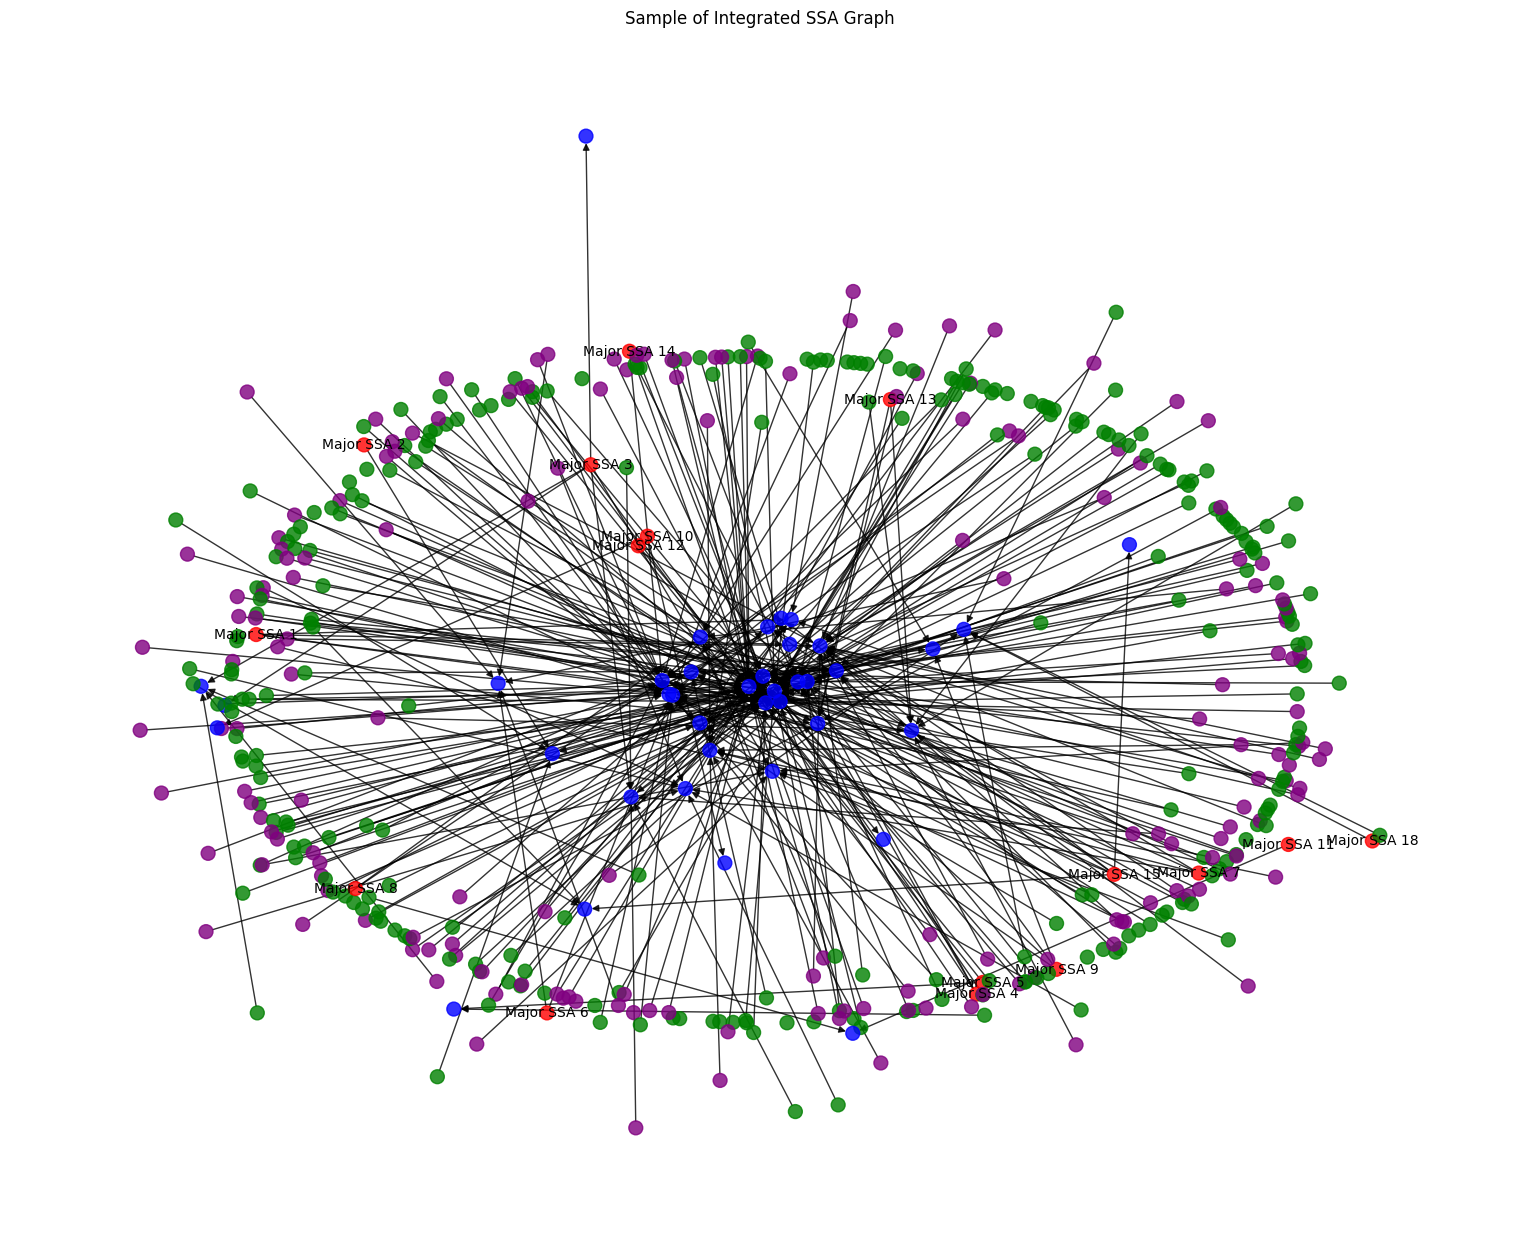

In [22]:
# Create a subgraph with just a sample of nodes
def create_sample_visualization(G, max_nodes=500):
    print(f"Creating sample visualization with max {max_nodes} nodes...")
    
    # First, include all SSA nodes as the backbone
    ssa_nodes = [n for n in G.nodes() if G.nodes[n]['type'] in ['major_ssa', 'sub_ssa']]
    
    # Then add a random sample of other nodes to reach desired size
    other_nodes = [n for n in G.nodes() if G.nodes[n]['type'] not in ['major_ssa', 'sub_ssa']]
    import random
    random.seed(42)  # For reproducibility
    
    # Calculate how many additional nodes to include
    remaining_slots = max(0, max_nodes - len(ssa_nodes))
    sampled_nodes = random.sample(other_nodes, min(remaining_slots, len(other_nodes)))
    
    # Create the subgraph
    nodes_to_include = ssa_nodes + sampled_nodes
    subgraph = G.subgraph(nodes_to_include)
    
    return subgraph

# Visualize a manageable subset
sample_graph = create_sample_visualization(G, max_nodes=500)
print(f"Sample graph has {sample_graph.number_of_nodes()} nodes and {sample_graph.number_of_edges()} edges")

plt.figure(figsize=(15, 12))
node_colors = {'major_ssa': 'red', 'sub_ssa': 'blue', 'nos': 'green', 'ofqual': 'purple'}
colors = [node_colors.get(sample_graph.nodes[n]['type'], 'gray') for n in sample_graph.nodes()]

# Use a faster layout algorithm for the sample
pos = nx.kamada_kawai_layout(sample_graph)  # More appropriate for smaller graphs
nx.draw(sample_graph, pos, with_labels=False, node_color=colors, node_size=100, alpha=0.8)

# Only label SSA categories
labels = {n: sample_graph.nodes[n]['name'] for n in sample_graph.nodes() 
         if sample_graph.nodes[n]['type'] in ['major_ssa']}
nx.draw_networkx_labels(sample_graph, pos, labels=labels, font_size=10)

plt.title("Sample of Integrated SSA Graph")
plt.savefig('sample_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Analyze graph structure rather than visualizing it
def analyze_graph_structure(G):
    print("\n=== Graph Analysis ===")
    
    # Basic statistics
    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Total edges: {G.number_of_edges()}")
    
    # Node type distribution
    node_types = {}
    for node, attrs in G.nodes(data=True):
        node_type = attrs.get('type', 'unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    print("\nNode type distribution:")
    for node_type, count in node_types.items():
        print(f"  - {node_type}: {count} nodes")
    
    # Compute degree statistics
    degrees = [d for n, d in G.degree()]
    print(f"\nDegree statistics:")
    print(f"  - Average degree: {sum(degrees)/len(degrees):.2f}")
    print(f"  - Min degree: {min(degrees)}")
    print(f"  - Max degree: {max(degrees)}")
    
    # Find most connected nodes
    top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 most connected nodes:")
    for node, degree in top_nodes:
        print(f"  - {G.nodes[node].get('name', node)}: {degree} connections")
    
    return node_types, degrees

# Run the analysis
node_types, degrees = analyze_graph_structure(G)


=== Graph Analysis ===
Total nodes: 27011
Total edges: 19493

Node type distribution:
  - major_ssa: 16 nodes
  - sub_ssa: 39 nodes
  - nos: 16040 nodes
  - ofqual: 10916 nodes

Degree statistics:
  - Average degree: 1.44
  - Min degree: 0
  - Max degree: 3451

Top 10 most connected nodes:
  - 5.2 Building and construction: 3451 connections
  - 4.2 Manufacturing technologies: 2214 connections
  - 4.1 Engineering: 1494 connections
  - 1.3 Health and social care: 1334 connections
  - 14.1 Foundations for learning and life: 927 connections
  - 7.4 Hospitality and catering: 920 connections
  - 15.3 Business management: 907 connections
  - 7.3 Service enterprises: 772 connections
  - 1.4 Public services: 558 connections
  - 4.3 Transportation operations and maintenance: 545 connections


In [24]:
from concurrent.futures import ThreadPoolExecutor
from tenacity import retry, wait_exponential, stop_after_attempt
import tqdm

@retry(wait=wait_exponential(min=1, max=10), stop=stop_after_attempt(3))
def embed_batch(batch_texts):
    """Embed a batch of texts with retry logic"""
    response = client.embeddings.create(
        input=batch_texts,
        model="text-embedding-3-small",
        encoding_format="float"  # Get floats directly
    )
    return [np.array(e.embedding, dtype=np.float32) for e in response.data]

def batch_embed_nodes(nodes, batch_size=2048, max_workers=8):
    """Parallel batch embedding with progress tracking"""
    # Prepare batches
    batches = []
    for i in range(0, len(nodes), batch_size):
        batch = nodes[i:i+batch_size]
        texts = [
            f"{data.get('title','')} {data.get('description','')} {data.get('keywords','')}"
            for _, data in batch
        ]
        batches.append(texts)
    
    # Process in parallel with progress bar
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(embed_batch, batch) for batch in batches]
        
        embeddings = []
        with tqdm.tqdm(total=len(futures), desc="Embedding nodes") as pbar:
            for future in futures:
                embeddings.extend(future.result())
                pbar.update(1)
    
    return torch.tensor(np.array(embeddings), dtype=torch.float32)


In [25]:
# Let's implement an RGCN (Relational Graph Convolutional Network) architecture using PyTorch Geometric
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data
import numpy as np
import random

def convert_nx_to_pyg(G):
    # Create node mapping
    nodes = list(G.nodes(data=True))
    node_mapping = {node: i for i, (node, _) in enumerate(nodes)}
    
    # Batch embed all nodes
    x = batch_embed_nodes(nodes)
    
    # Extract edge indices and relation types
    edge_index = []
    edge_type = []
    
    # Define relation types
    relation_types = set()
    for u, v, data in G.edges(data=True):
        relation_types.add(data.get('relation', 'default'))
    relation_to_idx = {rel: i for i, rel in enumerate(sorted(relation_types))}
    
    # Create edge indices and types
    for u, v, data in G.edges(data=True):
        u_idx = node_mapping[u]
        v_idx = node_mapping[v]
        rel_type = relation_to_idx[data.get('relation', 'default')]
        
        # Add both directions for undirected graphs
        edge_index.append([u_idx, v_idx])
        edge_type.append(rel_type)
        
        if not G.is_directed():
            edge_index.append([v_idx, u_idx])
            edge_type.append(rel_type)
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_type = torch.tensor(edge_type, dtype=torch.long)
    
    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, edge_type=edge_type)
    
    # Store node type information
    node_types = []
    type_to_idx = {}
    for node, node_data in G.nodes(data=True):
        node_type = node_data.get('type', 'unknown')
        if node_type not in type_to_idx:
            type_to_idx[node_type] = len(type_to_idx)
        node_types.append(type_to_idx[node_type])
    
    data.node_type = torch.tensor(node_types, dtype=torch.long)
    data.type_mapping = {v: k for k, v in type_to_idx.items()}
    
    # Store other metadata
    data.num_nodes = len(G.nodes())
    data.num_relations = len(relation_types)
    data.node_mapping = node_mapping
    data.relation_types = list(relation_to_idx.keys())
    
    return data

# Define the RGCN model
class RGCN(torch.nn.Module):
    def __init__(self, in_channels=1536, hidden_channels=512, out_channels=256, num_relations=5):
        super(RGCN, self).__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)
        
        # Add batch normalization and dropout
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(0.3)
        
        # Updated projection layer
        self.job_projection = torch.nn.Sequential(
            torch.nn.Linear(1536, 768),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(768),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(768, out_channels)
        )

    def forward(self, x, edge_index, edge_type):
        # First RGCN layer
        x = self.conv1(x, edge_index, edge_type)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second RGCN layer
        x = self.conv2(x, edge_index, edge_type)
        return x
    
    def project_job_embedding(self, job_embedding):
        return self.job_projection(job_embedding)

# Convert our NetworkX graph to PyG format
pyg_data = convert_nx_to_pyg(G)

print("\n=== PyTorch Geometric Data ===")
print(f"Number of nodes: {pyg_data.num_nodes}")
print(f"Number of edges: {pyg_data.edge_index.size(1)}")
print(f"Number of node features: {pyg_data.x.size(1)}")
print(f"Number of relation types: {pyg_data.num_relations}")

# Initialize the RGCN model
in_channels = pyg_data.x.size(1)  # Number of input features
hidden_channels = 64
out_channels = 32  # Embedding dimension
model = RGCN(in_channels, hidden_channels, out_channels, pyg_data.num_relations)

print("\n=== RGCN Model Architecture ===")
print(model)

# Training the RGCN model with contrastive learning for SSA-NOS-OFQUAL mapping
def train_rgcn(model, data, job_examples=None, epochs=100, margin=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    contrastive_loss = torch.nn.TripletMarginLoss(margin=margin)
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index, data.edge_type)
        
        # For SSA-based triplet formation
        loss = 0
        
        # Find nodes of each type using stored type mapping
        type_mapping = data.type_mapping
        node_types = data.node_type.tolist()
        
        sub_ssa_nodes = [i for i, t in enumerate(node_types)
                    if type_mapping[t] == 'sub_ssa']
        nos_nodes = [i for i, t in enumerate(node_types)
                if type_mapping[t] == 'nos']
        ofqual_nodes = [i for i, t in enumerate(node_types)
                    if type_mapping[t] == 'ofqual']
        
        
        # For each sub_ssa node as anchor
        if sub_ssa_nodes and (nos_nodes or ofqual_nodes):
            num_triplets = 0
            
            for anchor in sub_ssa_nodes:
                # Find connected NOS/OFQUAL nodes (positive examples)
                positives = []
                for i, (src, dst) in enumerate(data.edge_index.t().tolist()):
                    # Check for connections in either direction
                    if (src == anchor and (dst in nos_nodes or dst in ofqual_nodes)) or \
                       (dst == anchor and (src in nos_nodes or src in ofqual_nodes)):
                        positives.append(dst if src == anchor else src)
                
                # If we have positives, sample negatives and compute loss
                if positives:
                    all_candidates = nos_nodes + ofqual_nodes
                    negatives = [n for n in all_candidates if n not in positives]
                    
                    if negatives:
                        # Sample a positive and a negative
                        positive = random.choice(positives)
                        negative = random.choice(negatives)
                        
                        # Compute triplet loss
                        loss += contrastive_loss(
                            embeddings[anchor].unsqueeze(0),
                            embeddings[positive].unsqueeze(0),
                            embeddings[negative].unsqueeze(0)
                        )
                        num_triplets += 1
            
            # Average loss over all triplets
            if num_triplets > 0:
                loss = loss / num_triplets
                loss.backward()
                optimizer.step()

        # Add job description training
        if job_examples:
            job_loss = 0
            for job_embedding, true_nos_indices in job_examples:
                # Project job embedding
                job_projected = model.project_job_embedding(job_embedding)
                
                # Get similarities
                nos_similarities = torch.matmul(embeddings[nos_indices], job_projected)
                
                # Create triplets: job vs correct NOS vs incorrect NOS
                positive_idx = random.choice(true_nos_indices)
                negative_idx = random.choice([i for i in nos_indices if i not in true_nos_indices])
                
                job_loss += contrastive_loss(
                    job_projected.unsqueeze(0),
                    embeddings[positive_idx].unsqueeze(0),
                    embeddings[negative_idx].unsqueeze(0)
                )
            
            # Average job loss and backprop
            job_loss = job_loss / len(job_examples)
            job_loss.backward()
            optimizer.step() 
      
        if epoch == 0 or (epoch + 1) % 10 == 0:
            status = f"Loss: {loss.item():.4f}" if isinstance(loss, torch.Tensor) else "No valid triplets"
            print(f"Epoch {epoch+1}/{epochs}, {status}")
    
    return embeddings  # Return node embeddings


# Execute the model training
print("\n=== Training RGCN Model ===")
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set training parameters
epochs = 50  # Reduced from 100 for faster execution with large graph
learning_rate = 0.005  # Slightly reduced learning rate
margin = 0.3  # Contrastive learning margin

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model and data to device
model = model.to(device)
pyg_data.x = pyg_data.x.to(device)
pyg_data.edge_index = pyg_data.edge_index.to(device)
pyg_data.edge_type = pyg_data.edge_type.to(device)

# Train model and get embeddings
print("Starting training...")
embeddings = train_rgcn(model, pyg_data, epochs=epochs, margin=margin)
print("Training complete!")

# Save the trained model and embeddings
torch.save(model.state_dict(), 'trained_rgcn_model.pt')
torch.save(embeddings, 'node_embeddings.pt')
print("Model and embeddings saved to disk.")



print("\n=== Job-NOS-OFQUAL Mapping System ===")
print("The RGCN model learns to map job descriptions to relevant NOS competencies and OFQUAL qualifications")
print(f"Expected embedding dimensions: [{pyg_data.num_nodes}, {out_channels}]")

# How to use the trained embeddings for job description mapping
print("\n=== Practical Applications ===")
print("1. Job Description Analysis: Extract key skills from job descriptions and map to NOS standards")
print("2. Qualification Matching: Find relevant OFQUAL qualifications that cover the NOS competencies needed for a job")
print("3. Career Pathway Planning: Identify qualification pathways to bridge skill gaps for specific job roles")
print("4. Curriculum Alignment: Ensure training programs cover the NOS standards most relevant to industry needs")


Embedding nodes: 100%|██████████| 14/14 [02:55<00:00, 12.51s/it]



=== PyTorch Geometric Data ===
Number of nodes: 27011
Number of edges: 19493
Number of node features: 1536
Number of relation types: 2

=== RGCN Model Architecture ===
RGCN(
  (conv1): RGCNConv(1536, 64, num_relations=2)
  (conv2): RGCNConv(64, 32, num_relations=2)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (job_projection): Sequential(
    (0): Linear(in_features=1536, out_features=768, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=768, out_features=32, bias=True)
  )
)

=== Training RGCN Model ===
Using device: cpu
Starting training...
Epoch 1/50, Loss: 0.6636
Epoch 10/50, Loss: 0.4345
Epoch 20/50, Loss: 0.4903
Epoch 30/50, Loss: 0.3410
Epoch 40/50, Loss: 0.3499
Epoch 50/50, Loss: 0.2180
Training complete!
Model and embeddings saved to disk.

=== Job-NOS-OFQ

In [26]:
# Sample job description (Business Development Manager)
job_description = """
Business Unit/Function
Centrica Business Solutions
Business Job Title
Finance Manager – Centrica Energy Assets

Job Overview
Main Purpose of the role
Summarise in 1 or 2 sentences the main purpose & objectives of the role, explain WHY the job exists and WHAT it must achieve. This should describe the aim of the job, e.g., WHAT is done, to WHAT/WHOM, to WHAT end.
	•	Centrica Energy Assets (CEA) is a growing business set up in 2021 with a mission is to build our sustainable energy future. To do that we develop, build, operate & manage our own utility scale solar, battery & gas assets to enable the energy transition. We have an ambitious target of reaching 1GW operational asset portfolio by 2028 which is a key part of Centrica’s commitment towards reaching net zero by 2045.
	•	CEA Finance Manager role will provide commercial finance support to the business and its growth plans in the development, construction and operation of grid scale decarbonisation assets, with the provision of robust financial reporting and analysis, planning and forecasts to the business and wider Centrica Group.

Key Accountabilities of the role
Identify the six to eight main things the job holder must do to make sure the main purpose is met. The things and/or services which need to be provided. Ensure each accountability states what is done, to what/whom and with what outcome (e.g., prepare, monitor, control…the annual departmental budget…ensure expenditure is in line with the business plan).
Core Finance
	•	Lead Group Annual Plan, Group Financial Forecasts and latest view processes in CEA, supporting business review of financial and operational value drivers to identify corrective actions in an accurate, efficient and transparent manner which meets finance and business stakeholder requirements
	•	Translate CEA’s pipeline of origination pipeline, in-flights projects and asset operations in “find, build and run” activities respectively into modelling of five-year strategic shape in line with Centrica strategy in solar, battery and gas peaker technologies
	•	Support the wider finance team and business by providing robust, insight and analysis to drive improvements in financial performance
	•	Lead and continuously improve the suite of CEA self-serve reporting tools through best optimal usage of SAP, PowerBI and PowerQuery driving better automation and structure
	•	Produce standard finance deliverables to the agreed format, timeline and quality, supported by clear and focused messaging
Business Partnering
	•	FIND: Support and challenge Origination, Commercial & Investments team in reviewing and updating long term economic models, understanding the key drivers of revenue, opex and capex in the UK/European power generation sectors, ensuring the team use best practice financial modelling techniques
	•	FIND: Support M&A activity through running financial due diligence and review of contract terms working in collaboration with commercial and legal. Drive the integration and hive-up of acquired entities into existing Centrica systems and processes
	•	FIND: Carry out non-standard / bespoke analysis to support business decision making including investment cases
	•	BUILD: Develop and embed scalable projects processes and monitor delivery performance in close relationship with project managers and cost controllers, ensuring effective cost control environment in line with CBS risk & controls framework
	•	RUN: Develop insights in assets operational and financial performance in collaboration with Operations and EM&T

Key Stakeholders
Identify the key stakeholders the job holder interacts with to fulfil their role (e.g., manager, peers within and outside immediate team, subordinates, clients/customers, suppliers,). Ensure each key stakeholder states the type of contact (e.g., telephone, face-to-face, email, meetings), the typical reason for contact (e.g., obtain information, give advice, sell, influence, motivate, develop), and the frequency of the contact (e.g., daily, weekly, monthly).
	•	CEA managing director, department heads and teams
	•	CBS Finance particularly Financial Control, Strategy and BPM
	•	Group Finance and M&A
	•	CBS functional teams Legal, DTS, HR and HSES
Leadership Team Membership 
Describe any Leadership Team Membership (e.g., CLT, S&S LT, Group HRLT etc.,) if applicable.
	•	

Required Knowledge, Skills & Experience
Work Experience & Functional/Technical Skills required 
Describe the experience and skills necessary to perform the role effectively. How much work experience is necessary? What key technical/functional skills or specific business knowledge is necessary? 
	•	Financial modelling skills
	•	Digital skills in Microsoft reporting and visualisation tools
	•	Knowledge of the UK energy / power generation sector preferred, but not essential

Education and Certifications required to perform the role
Identify the level of education or certifications necessary to perform the role effectively (e.g., level and subject of university degree, technical certification, project management certification).
	•	Fully qualified accountant from a recognised body (ACA, ACCA, ICAS, CIMA)

Key Competencies/Core Capabilities required to perform the role
Describe key behavioural competencies and core capabilities necessary to perform the role effectively (e.g., teamwork, customer focused, working with ambiguity, agility, planning).
	•	Teamwork across business and finance
	•	Work with agility under uncertainty in business’ deal making and M&A agenda

"""

In [27]:
def test_rgcn_with_job_description(job_desc, model, pyg_data, nos_df, ofqual_df, top_k=5):
    # 1. Generate OpenAI embedding with proper dimensions
    client = openai.OpenAI()
    response = client.embeddings.create(input=[job_desc], model="text-embedding-3-small")
    job_embedding = torch.tensor(response.data[0].embedding, device=device).unsqueeze(0)  # Add batch dimension
    
    # 2. Get node indices using stored type information
    node_ids = list(pyg_data.node_mapping.keys())
    type_mapping = pyg_data.type_mapping
    node_types = pyg_data.node_type.tolist()
    
    # Get indices by type
    nos_indices = [i for i, t in enumerate(node_types) if type_mapping[t] == 'nos']
    ofqual_indices = [i for i, t in enumerate(node_types) if type_mapping[t] == 'ofqual']


    # 3. Project and calculate similarities
    with torch.no_grad():
        model.eval()
        job_projected = model.job_projection(job_embedding)
        node_embeddings = model(pyg_data.x, pyg_data.edge_index, pyg_data.edge_type)
        
        # Calculate similarities using type-filtered embeddings
        nos_sim = F.cosine_similarity(job_projected, node_embeddings[nos_indices])
        ofqual_sim = F.cosine_similarity(job_projected, node_embeddings[ofqual_indices])

    # 4. Get top matches with improved error handling
    def get_top_matches(similarities, indices, df, node_type):
        top_scores, top_idx = torch.topk(similarities, min(top_k, len(indices)))
        results = []
        for score, idx in zip(top_scores, top_idx):
            node_id = node_ids[indices[idx]]
            try:
                record_id = int(node_id.split('_')[-1])
                if record_id < len(df):
                    results.append((df.iloc[record_id], score.item()))
            except (ValueError, IndexError):
                print(f"Warning: Invalid {node_type} node ID format: {node_id}")
        return results

    # 5. Retrieve results
    nos_results = get_top_matches(nos_sim, nos_indices, nos_df, 'NOS')
    ofqual_results = get_top_matches(ofqual_sim, ofqual_indices, ofqual_df, 'OFQUAL')

    # 6. Print formatted results
    print("\n=== Best NOS Matches ===")
    for i, (row, score) in enumerate(nos_results):
        print(f"\n{i+1}. Score: {score:.4f}")
        print(f"ID: {row.get('nos_id', 'N/A')}")
        print(f"Title: {row.get('title_x', 'N/A')}")
        print(f"Description: {row.get('overview', 'N/A')[:150]}...")

    print("\n=== Best OFQUAL Matches ===")
    for i, (row, score) in enumerate(ofqual_results):
        print(f"\n{i+1}. Score: {score:.4f}")
        print(f"ID: {row.get('id', 'N/A')}")
        print(f"Title: {row.get('title', 'N/A')}")
        print(f"Description: {row.get('description', 'N/A')[:150]}...")

    return {'nos': nos_results, 'ofqual': ofqual_results}

# Usage
test_results = test_rgcn_with_job_description(
    job_description,  # Your JD text
    model,            # Trained RGCN model
    pyg_data,         # Graph data
    nos_merged,       # NOS dataframe
    ofqual_df,        # OFQUAL dataframe
    top_k=10
)


=== Best NOS Matches ===

1. Score: 0.4378
ID: SKSJ12
Title: Report on Government and Politics in the UK
Description: This Standard focuses on reporting the intricacies of the UK political system, covering its various institutions, policy-making processes, and the rel...

2. Score: 0.4102
ID: IMPDT111
Title: Operate and monitor a distillery blending process
Description: This standard outlines the skills and knowledge required to effectively operate and monitor the blending process in distilling operations, focusing on...

3. Score: 0.3902
ID: PPL 2QS4
Title: Prepare coated food
Description: This NOS standard outlines the requirements for employees whose primary role is to prepare food by coating it with batter or breadcrumbs, typically on...

4. Score: 0.3858
ID: PPLGS2010
Title: Reconcile takings for bingo books and tickets
Description: This NOS document outlines the skills and knowledge necessary to accurately reconcile takings from bingo books and tickets, ensuring the security of 

In [30]:
# Sample job description (Business Development Manager)
job_description = """
Business Unit/Function
Centrica Business Solutions
Business Job Title
Finance Manager – Centrica Energy Assets

Job Overview
Main Purpose of the role
Summarise in 1 or 2 sentences the main purpose & objectives of the role, explain WHY the job exists and WHAT it must achieve. This should describe the aim of the job, e.g., WHAT is done, to WHAT/WHOM, to WHAT end.
	•	Centrica Energy Assets (CEA) is a growing business set up in 2021 with a mission is to build our sustainable energy future. To do that we develop, build, operate & manage our own utility scale solar, battery & gas assets to enable the energy transition. We have an ambitious target of reaching 1GW operational asset portfolio by 2028 which is a key part of Centrica’s commitment towards reaching net zero by 2045.
	•	CEA Finance Manager role will provide commercial finance support to the business and its growth plans in the development, construction and operation of grid scale decarbonisation assets, with the provision of robust financial reporting and analysis, planning and forecasts to the business and wider Centrica Group.

Key Accountabilities of the role
Identify the six to eight main things the job holder must do to make sure the main purpose is met. The things and/or services which need to be provided. Ensure each accountability states what is done, to what/whom and with what outcome (e.g., prepare, monitor, control…the annual departmental budget…ensure expenditure is in line with the business plan).
Core Finance
	•	Lead Group Annual Plan, Group Financial Forecasts and latest view processes in CEA, supporting business review of financial and operational value drivers to identify corrective actions in an accurate, efficient and transparent manner which meets finance and business stakeholder requirements
	•	Translate CEA’s pipeline of origination pipeline, in-flights projects and asset operations in “find, build and run” activities respectively into modelling of five-year strategic shape in line with Centrica strategy in solar, battery and gas peaker technologies
	•	Support the wider finance team and business by providing robust, insight and analysis to drive improvements in financial performance
	•	Lead and continuously improve the suite of CEA self-serve reporting tools through best optimal usage of SAP, PowerBI and PowerQuery driving better automation and structure
	•	Produce standard finance deliverables to the agreed format, timeline and quality, supported by clear and focused messaging
Business Partnering
	•	FIND: Support and challenge Origination, Commercial & Investments team in reviewing and updating long term economic models, understanding the key drivers of revenue, opex and capex in the UK/European power generation sectors, ensuring the team use best practice financial modelling techniques
	•	FIND: Support M&A activity through running financial due diligence and review of contract terms working in collaboration with commercial and legal. Drive the integration and hive-up of acquired entities into existing Centrica systems and processes
	•	FIND: Carry out non-standard / bespoke analysis to support business decision making including investment cases
	•	BUILD: Develop and embed scalable projects processes and monitor delivery performance in close relationship with project managers and cost controllers, ensuring effective cost control environment in line with CBS risk & controls framework
	•	RUN: Develop insights in assets operational and financial performance in collaboration with Operations and EM&T

Key Stakeholders
Identify the key stakeholders the job holder interacts with to fulfil their role (e.g., manager, peers within and outside immediate team, subordinates, clients/customers, suppliers,). Ensure each key stakeholder states the type of contact (e.g., telephone, face-to-face, email, meetings), the typical reason for contact (e.g., obtain information, give advice, sell, influence, motivate, develop), and the frequency of the contact (e.g., daily, weekly, monthly).
	•	CEA managing director, department heads and teams
	•	CBS Finance particularly Financial Control, Strategy and BPM
	•	Group Finance and M&A
	•	CBS functional teams Legal, DTS, HR and HSES
Leadership Team Membership 
Describe any Leadership Team Membership (e.g., CLT, S&S LT, Group HRLT etc.,) if applicable.
	•	

Required Knowledge, Skills & Experience
Work Experience & Functional/Technical Skills required 
Describe the experience and skills necessary to perform the role effectively. How much work experience is necessary? What key technical/functional skills or specific business knowledge is necessary? 
	•	Financial modelling skills
	•	Digital skills in Microsoft reporting and visualisation tools
	•	Knowledge of the UK energy / power generation sector preferred, but not essential

Education and Certifications required to perform the role
Identify the level of education or certifications necessary to perform the role effectively (e.g., level and subject of university degree, technical certification, project management certification).
	•	Fully qualified accountant from a recognised body (ACA, ACCA, ICAS, CIMA)

Key Competencies/Core Capabilities required to perform the role
Describe key behavioural competencies and core capabilities necessary to perform the role effectively (e.g., teamwork, customer focused, working with ambiguity, agility, planning).
	•	Teamwork across business and finance
	•	Work with agility under uncertainty in business’ deal making and M&A agenda

"""

# Run the test
test_results = test_rgcn_with_job_description(job_description, model, pyg_data, nos_merged, ofqual_df, top_k=10)



=== Best NOS Matches ===

1. Score: 0.4378
ID: SKSJ12
Title: Report on Government and Politics in the UK
Description: This Standard focuses on reporting the intricacies of the UK political system, covering its various institutions, policy-making processes, and the rel...

2. Score: 0.4102
ID: IMPDT111
Title: Operate and monitor a distillery blending process
Description: This standard outlines the skills and knowledge required to effectively operate and monitor the blending process in distilling operations, focusing on...

3. Score: 0.3902
ID: PPL 2QS4
Title: Prepare coated food
Description: This NOS standard outlines the requirements for employees whose primary role is to prepare food by coating it with batter or breadcrumbs, typically on...

4. Score: 0.3858
ID: PPLGS2010
Title: Reconcile takings for bingo books and tickets
Description: This NOS document outlines the skills and knowledge necessary to accurately reconcile takings from bingo books and tickets, ensuring the security of 